
# GEOS 518 Notebook 2: Autoregressive Models

## By: Zakk Hess
## February 28th, 2018

### Overview of Analysis

In this analysis each of the following procedures will be executed on a timeseries of daily observed temperature at Bogus Basin (Idaho, USA).
Dataset downloaded from SNOTEL site through the NRCS (https://www.wcc.nrcs.usda.gov/snow/)

    1. Read in the dataset and perform any additional pre-processing needed
    2. Split the dataset into a "training" dataset used to estimate the parameters of the AR model, and a "test" dataset against which you will test the model
    3. Estimate the parameters of an AR(1) model using the training dataset
        * Compute the autocorrelation function
        * Use Yule-Walker equations to estimate the AR(1) parameters
        * Use the statsmodel AR tools to estimate the parameters based on the dataset
        * Compare the YW parameters to those from the statsmodel library
    4. Estimate the parameters of an AR(2) model using the training dataset
        * Use Yule-Walker equations to estimate the AR(2) parameters
        * Use the statsmodel AR tools to estimate the parameters based on the dataset
        * Compare the YW parameters to those from the statsmodel library
    5. Apply the AR(1) and AR(2) models to the \"test\" dataset (the one withheld from parameter estimation)
    6. Plot the modeled time series for the AR(1) and AR(2) models against the observed time series for comparison
    7. Comment on key differences and distinctions between the models themselves and the extent to which they reproduce the observations

## 1. Read in the dataset and perform any necessary pre-processing 

In [1]:
#import libraries to be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import statsmodels.tsa.api as sm
from pandas.core import datetools



df = pd.read_csv('BB_AirT_12_17.csv', names=['Y','M','D','T(C)']) #load CSV into variable df
df['SerialDates'] = pd.to_datetime(df.Y*10000+df.M*100+df.D,format='%Y%m%d') #use YMD to make date (SerialDates)


# Create a Water Year column for our pandas data frame
WY = np.zeros(len(df['Y'].index)) #Create an empty array of zeros length of years
WY[df['M'].values < 10] = df['Y'].values[df['M'].values < 10] #records where the month is less than 10, their associated year is the correct water year
WY[df['M'].values >= 10] = df['Y'].values[df['M'].values >= 10] + 1 #records where the month is greater than or equal to 10,the correct water year is one more than the current calendar year
df['WY'] = WY.astype(int) #create column water year in data frame as an integer

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  


## 2. Splitting dataset into "training" dataset used to estimate the parameters of the AR model, and a "test" dataset to test the model

In [2]:
df_train = df[df.WY != 2016] #create training dataset, everything not WY 016
df_test  = df[df.WY == 2016] #create test dataset, all of WY 2016

## Examine the Structure of the Partial Autocorrelation Function 

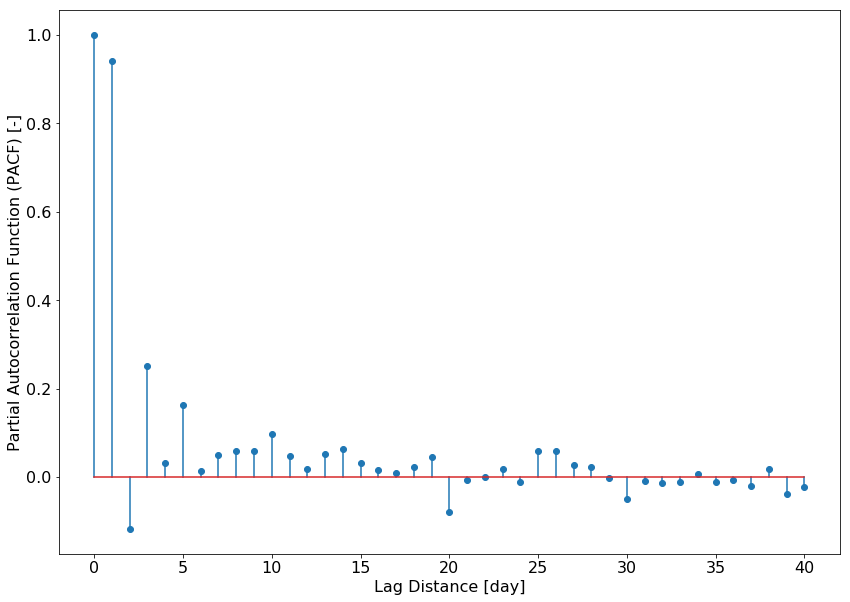

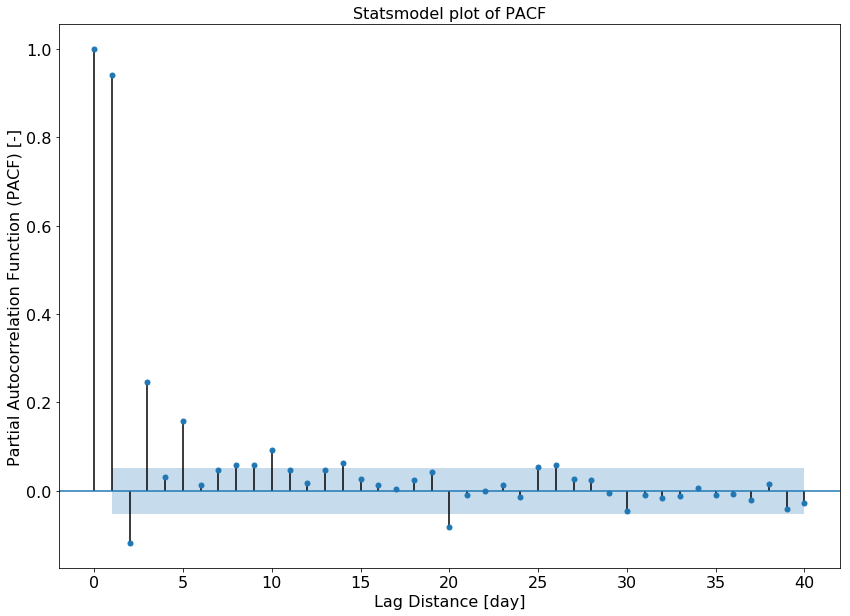

In [3]:
Tt = pd.Series(df_train['T(C)'].values,df_train['SerialDates'].values) #time series of T and Serial dates

Tpacf = sm.pacf(Tt) #pacf = partial autocoreelation function

#plot partial autocorrelation function
plt.figure(figsize=(14,10))
plt.stem(Tpacf)
plt.ylabel('Partial Autocorrelation Function (PACF) [-]',fontsize=16)
plt.xlabel('Lag Distance [day]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.show()

#use built in statsmodel tool to plot partial autocoreelation function
#use subplot to see difference between the two
from statsmodels.graphics.tsaplots import plot_pacf
f, axarr = plt.subplots(1, 1, figsize=(14,10))
_ = plot_pacf(Tt,method='ols',lags=40,ax=axarr.axes)
axarr.set_title('Statsmodel plot of PACF',fontsize=16)
axarr.set_ylabel('Partial Autocorrelation Function (PACF) [-]',fontsize=16)
axarr.set_xlabel('Lag Distance [day]',fontsize=16)
axarr = plt.gca()
axarr.tick_params('both',labelsize=16)
plt.show()

## 3. Estimate the parameters of an AR(1) model using the training dataset

### Compute the autocorrelation function

In [108]:
T = df_train['T(C)'].values #training
Tt   = T[1:-1] #array t+1 to t-1
Ttm1 = T[0:-2] #array t to t-2
R1 = np.corrcoef(Ttm1,Tt) #determine autocorrelation value
R1 = round(R1[1,0],5) #round to 5 places
print('The autocorrelation function at lag 1 is:', R1) #display vlaue

The autocorrelation function at lag 1 is: 0.94063


### AR(1) parameters estimated with Yule-Walker equations

In [109]:
AR1_phi1 = R1 #phi1 = autocorrelation value
print(u'AR(1) \u03A6\u2081 using YW equations is:', AR1_phi1) #print value

AR(1) Φ₁ using YW equations is: 0.94063


### Statsmodel AR tools to estimate the parameters based on the dataset

In [117]:
Tt = pd.Series(df_train['T(C)'].values, df_train['SerialDates'].values) #to use with statsmodel tool
T_AR1_model = sm.AR(Tt).fit(1) #determine paramters with statsmodel tool
print(T_AR1_model.params) #print values
print()
print(u'AR(1) \u03A6\u2081 using statsmodel AR tools is: 0.94027') #print output of phi1

const    0.371889
L1.y     0.940270
dtype: float64

AR(1) Φ₁ using statsmodel AR tools is: 0.94027


### Comparison of the YW parameters to those from the statsmodel library

In [120]:
PercDiff = abs(((0.94027 - AR1_phi1)/0.94027)*100) #determine difference bw statmodel and YW
print(u'The difference between AR(1) \u03A6\u2081 using YW equations vs. statsmodel tools is:',
      round(PercDiff,4), '%')

The difference between AR(1) Φ₁ using YW equations vs. statsmodel tools is: 0.0383 %


The difference between the two methods to calculate AR(1) parameters differs by less than a tenth of a percent. This difference is so small that it is neglible, either method is sufficient for determining parameters to be used in the AR(1) model.

## 4. Estimate the parameters of an AR(2) model using the training dataset

### Compute the autocorrelation function

In [123]:
T = df_train['T(C)'].values #use training values
Tt   = T[2:-1] #lag two days
Ttm1 = T[0:-3]
R2 = np.corrcoef(Ttm1,Tt) #get autocorrelation value for 2 day lag
R2 = round(R2[1,0],5) #roung to 5 places
print('The autocorrelation function at lag 2 is:', R2) #print value

The autocorrelation function at lag 2 is: 0.87109


### AR(2) parameters estimated with Yule-Walker equations

In [124]:
AR2_phi1 = (1-(((R1**2)-R2)/((R1**2)-1)))*R1 #YW calculation AR2 for phi1
AR2_phi2 = ((R1**2)-R2)/((R1**2)-1) #YW calculation for AR2 phi2

print(u'AR(2) \u03A6\u2081 using YW equations is:', round(AR2_phi1,5)) #print value
print(u'AR(2) \u03A6\u2082 using YW equations is:', round(AR2_phi2,5)) #print value

AR(2) Φ₁ using YW equations is: 1.05244
AR(2) Φ₂ using YW equations is: -0.11886


### Statsmodel AR tools to estimate the parameters based on the dataset

In [129]:
Tt = pd.Series(df_train['T(C)'].values, df_train['SerialDates'].values) #to use with statsmodel tool
T_AR2_model = sm.AR(Tt).fit(2) #statsmodel tool to detemine paramters (phi1 and phi2)
print(T_AR2_model.params) #print parameters
print()
print(u'AR(2) \u03A6\u2081 using statsmodel AR tools is: 1.05157') #print phi1 value
print(u'AR(2) \u03A6\u2082 using statsmodel AR tools is: -0.11817') #print phi2 value

const    0.416538
L1.y     1.051570
L2.y    -0.118172
dtype: float64

AR(2) Φ₁ using statsmodel AR tools is: 1.05157
AR(2) Φ₂ using statsmodel AR tools is: -0.11817


### Comparison of the YW parameters to those from the statsmodel library

In [130]:
#Difference of Phi1
PercDiff1 = abs(((1.05157 - AR2_phi1)/1.05157)*100)
#Difference of Phi2
PercDiff2 = abs(((-0.11817 - AR2_phi2)/-0.11817)*100)

print(u'The difference between AR(2) \u03A6\u2081 using YW equations vs. statsmodel tools is:',
      round(PercDiff1,4), '%')
print(u'The difference between AR(2) \u03A6\u2082 using YW equations vs. statsmodel tools is:',
      round(PercDiff2,5), '%')

The difference between AR(2) Φ₁ using YW equations vs. statsmodel tools is: 0.0823 %
The difference between AR(2) Φ₂ using YW equations vs. statsmodel tools is: 0.58624 %


The difference between the two methods to calculate AR(2) parameters (phi1 and phi2) differs by less than 1% for each. This difference is so small that it is neglible, however, we see with this that as our lag gets bigger, parameter estimations gets tougher and as more parameters become involved that are dependent on other estimated parameters, there will be less agreeance. As the YW equations and statsmodel tools agree to within 1% we can assume either method is sufficient for determining parameters to be used in the AR(2) model.

## 5. Apply the AR(1) and AR(2) models to the "test" dataset 

In [131]:
Ttrain = df_train['T(C)'].values #training data
Ttest  = df_test['T(C)'].values #test data

DatesTest = df_test['SerialDates'].values #dates for test daya

Tttm1 = np.concatenate([Ttrain[-2:-1],Ttest[0:-1]]) #add extra spots for adjustment of 1 day lag
Tttm2 = np.concatenate([Ttrain[-3:-1],Ttest[0:-2]]) #add extra spots for adjustment of 2 day lag

AR1_mu   = T_AR1_model.params[0] #AR1 mu variable from statsmodel parameters
AR1_phi1 = T_AR1_model.params[1] #AR1 phi variable from statsmodel parameters

ThatAR1 = AR1_mu + AR1_phi1*Tttm1 #modeled values of AR1 model

AR2_mu   = T_AR2_model.params[0] #AR2 mu variable from statsmodel parameters
AR2_phi1 = T_AR2_model.params[1] #AR2 phi1 variable from statsmodel parameters 
AR2_phi2 = T_AR2_model.params[2] #AR2 phi2 variable from statsmodel parameters

ThatAR2 = AR2_mu + AR2_phi1*Tttm1 + AR2_phi2*Tttm2 #modeled values of AR2 model

## 6. Plot the modeled time series for the AR(1) and AR(2) models against the observed time series

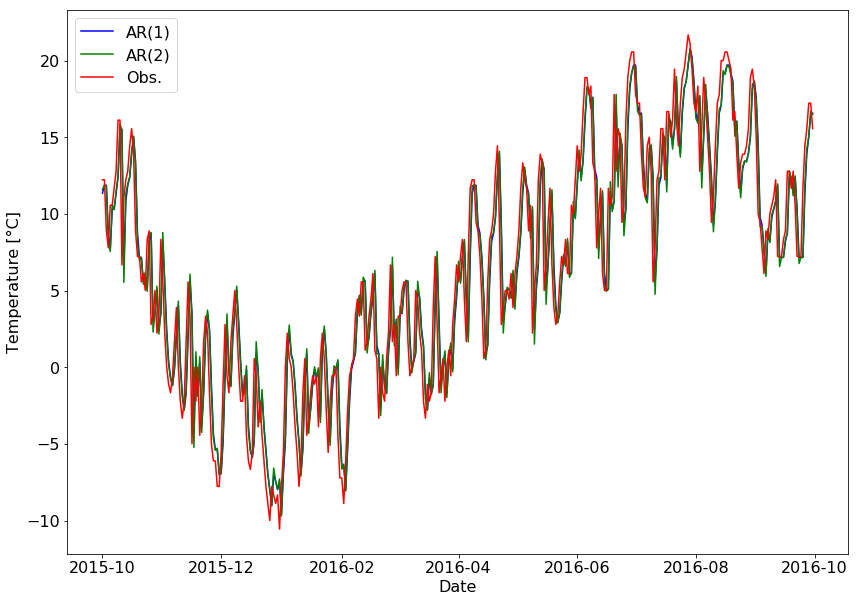

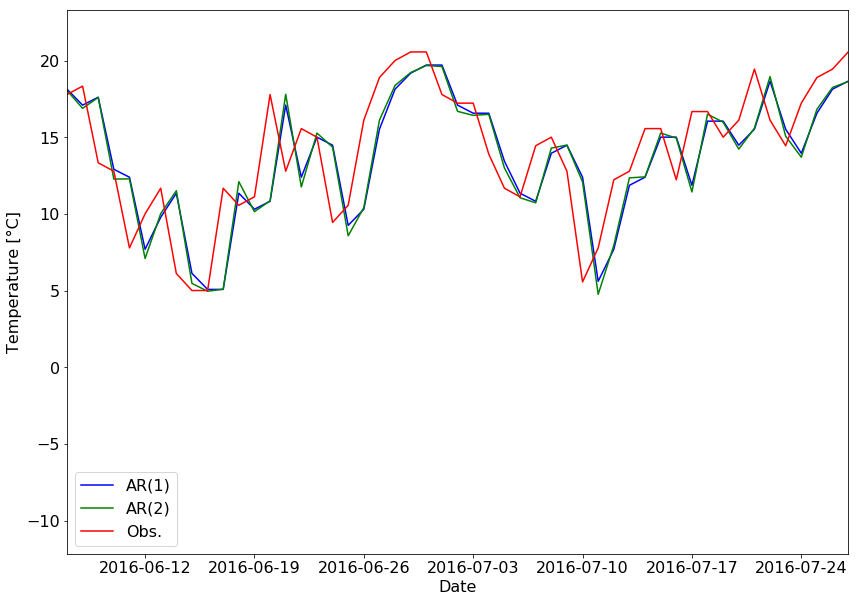

In [132]:
#create figure and plot AR1 modeled data, AR2 modeled data, and observed data
plt.figure(figsize=(14,10))

plt.plot(DatesTest,ThatAR1,'b-')
plt.plot(DatesTest,ThatAR2,'g-')
plt.plot(DatesTest,Ttest,'r-')
plt.ylabel('Temperature [\N{DEGREE SIGN}C]',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.legend(('AR(1)','AR(2)','Obs.'),fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.show()

#create figure and plot AR1 modeled data, AR2 modeled data, and observed data, "zoomed in"
plt.figure(figsize=(14,10))
plt.plot(DatesTest,ThatAR1,'b-')
plt.plot(DatesTest,ThatAR2,'g-')
plt.plot(DatesTest,Ttest,'r-')
plt.xlim([DatesTest[250],DatesTest[300]])
plt.ylabel('Temperature [\N{DEGREE SIGN}C]',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.legend(('AR(1)','AR(2)','Obs.'),fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.show()

## Compare the Predictions with Observations

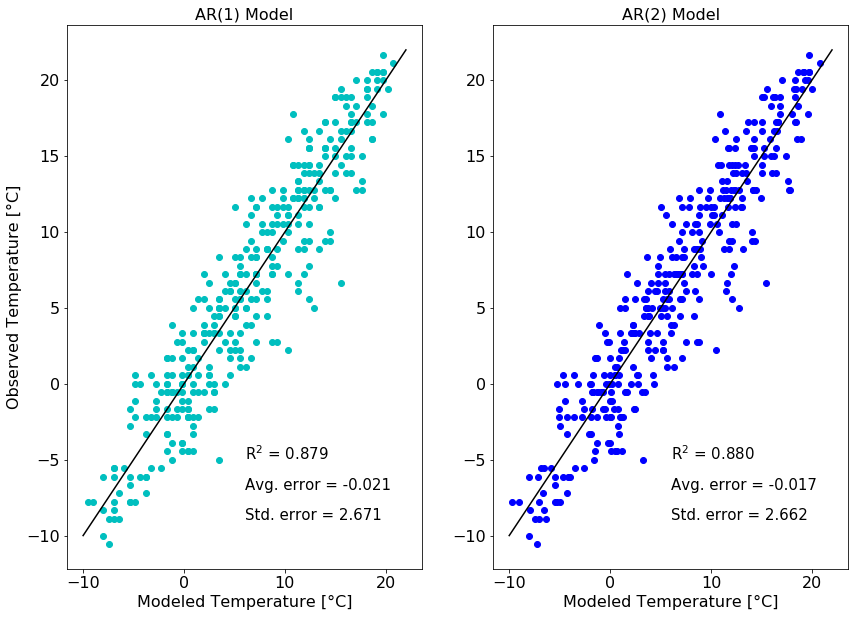

In [133]:
# Compute the R^2 values and other statistics for each prediction 
R2AR1  = np.corrcoef(ThatAR1,Ttest)**2
R2AR2  = np.corrcoef(ThatAR2,Ttest)**2
muAR1  = np.mean(ThatAR1-Ttest)
stdAR1 = np.std(ThatAR1-Ttest)
muAR2  = np.mean(ThatAR2-Ttest)
stdAR2 = np.std(ThatAR2-Ttest)

# Plot the AR(1) and AR(2) model results 
plt.figure(figsize=(14,10))
plt.subplot(121)
plt.plot(ThatAR1,Ttest,'co')
plt.plot([-10, 22], [-10, 22], 'k-')
plt.title('AR(1) Model',fontsize=16)
plt.ylabel('Observed Temperature [\N{DEGREE SIGN}C]',fontsize=16)
plt.xlabel('Modeled Temperature [\N{DEGREE SIGN}C]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
#plot statistics on figure
ax.annotate('R${}^2$ = %.3f'%R2AR1[0,1], xy=(6,-5), fontsize=15)
ax.annotate('Avg. error = %.3f'%muAR1, xy=(6,-7), fontsize=15)
ax.annotate('Std. error = %.3f'%stdAR1, xy=(6,-9), fontsize=15)

plt.subplot(122)
plt.plot(ThatAR2,Ttest,'bo')
plt.plot([-10, 22], [-10, 22], 'k-')
plt.title('AR(2) Model',fontsize=16)
plt.xlabel('Modeled Temperature [\N{DEGREE SIGN}C]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
#plot statistics on figure
ax.annotate('R${}^2$ = %.3f'%R2AR2[0,1], xy=(6,-5), fontsize=15)
ax.annotate('Avg. error = %.3f'%muAR2, xy=(6,-7), fontsize=15)
ax.annotate('Std. error = %.3f'%stdAR2, xy=(6,-9), fontsize=15)

plt.show()

## 7. Key differences and distinctions between the models themselves and the extent to which they reproduce the observations

The Autoregressive models both reproduce the actual observed temperature squite well. The R^2 for both the AR(1) and AR(2) models are ~ 0.88, showing a strong correlation / agreeance between modeled values and actual observed values of temperature. The biggest difference between the two is a lag of 1 day vs. a lag of 2 days, and more parameters taken into consideration in the AR(2) model.

Comparing the performance of AR(1) and AR(2), the models perform quite comparably. From a qualitative perspective, it seems as if AR(1) may be a slightly better fit than AR(2), but after a quantitative analysis, it is evident that the AR(2) model slightly outperforms the AR(1) model. The R^2 value is slightly higher (0.880 vs. 0.879), the average error is lower (-0.010 vs. -0.015), and the standard error is lower (2.662 vs. 2.671).